# Plotting enrichment in kegg pathways from Corsair results

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Get the data. KEGG pathway, ratio of genes ((count / total genes in set) / number of genes in KEGG pathway)

In [3]:
## These are for plotting labels later
names = {
    'hsap' : 'Primates',
    'mluc' : 'Ciroptera',
    'pman' : 'Cricetidae',
    'mmus' : 'Murinae',
    'btau' : 'Bovidae',
    'clup' : 'Caniformia'
}

## main df dictionary to hold all our dfs
keggs = {}
keggs['hsap'] = pd.read_csv("kegg_counting/Hsap_kegg_counting.csv")
keggs['mluc'] = pd.read_csv("kegg_counting/Mluc_kegg_counting.csv")
keggs['pman'] = pd.read_csv("kegg_counting/Pman_kegg_counting.csv")
keggs['mmus'] = pd.read_csv("kegg_counting/Mmus_kegg_counting.csv")
keggs['btau'] = pd.read_csv("kegg_counting/Btau_kegg_counting.csv")
keggs['clup'] = pd.read_csv("kegg_counting/Clup_kegg_counting.csv")

keggs['hsap'].head()

,Pathway,Ratio,Hits,Total
0,Carbohydrate metabolism,0.000043,37,357
1,Energy metabolism,0.000021,8,159
2,Lipid metabolism,0.000041,39,393
3,Nucleotide metabolism,0.000037,14,155
4,Amino acid metabolism,0.000039,27,289


Only allow categories where we have at least X genes in the pathway

In [13]:
min_genes = 5

for kegg in keggs:
    keggs[kegg] = keggs[kegg][keggs[kegg]['Total'] >= 5]

In [14]:
def plot_pathways(df_dict, names, pathways):
    """
    Input: Dictionary of the data frames, dictionary of names for plotting, list of pathways to plot
    Output: Plot of those pathway enrichment values
    """
    plotdf = pd.DataFrame(columns=('Pathway','Clade','Ratio'))

    for kegg in df_dict:
        df = df_dict[kegg]
        for top in pathways:
            pathway = top
            clade = names[kegg]
            ratio = float(df[df['Pathway'] == top].values[0][1])
            d1 = pd.DataFrame(np.array([[pathway,clade,ratio]]), columns=['Pathway', 'Clade', 'Ratio'])
            plotdf = plotdf.append(d1)
    plotdf = plotdf.reset_index(drop=True)
    plotdf['Pathway'] = plotdf['Pathway'].astype(str)
    plotdf['Clade'] = plotdf['Clade'].astype(str)
    plotdf['Ratio'] = plotdf['Ratio'].astype(float)
    
    ## colors (first few are just other options)
    brown_to_green = ["#8c510a", "#d8b365", "#f6e8c3", "#c7eae5", "#5ab4ac", "#01665e"]
    pastels = ["#7fc97f", "#beaed4", "#fdc086", "#ffff99", "#386cb0", "#f0027f"]
    sequence = ["#ffffcc", "#c7e9b4", "#7fcdbb", "#41b6c4", "#2c7fb8", "#253494"] 
    sequence2 = ["#fb6a4a", "#016c59", "#31a354", "#1c9099", "#67a9cf", "#253494"] 
    qualitative = ["#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e", "#e6ab02"]

    ## actual plot
    plt.figure(figsize=(12,25))
    ax = sns.barplot(
        data = plotdf,
        x = "Ratio", 
        y = "Pathway", 
        hue = "Clade", 
        palette = qualitative,
        saturation = 0.75
    )

## 1) Find the top 5 most common pathways in each set, see how each set compares

In [15]:
def most_common(df, X):
    """
    Find the X most common kegg pathways in the data frame
    Return a list of the pathways
    """
    df = df.sort_values(by=['Ratio'], ascending=False)
    df = df.head(X)
    return df['Pathway'].values

Make a data frame that has the properties [Pathway,Clade,Ratio] such that the pathways are from the tops list and we have the ratio for each clade for each pathway.

Top pathways / total possible: 25 / 30


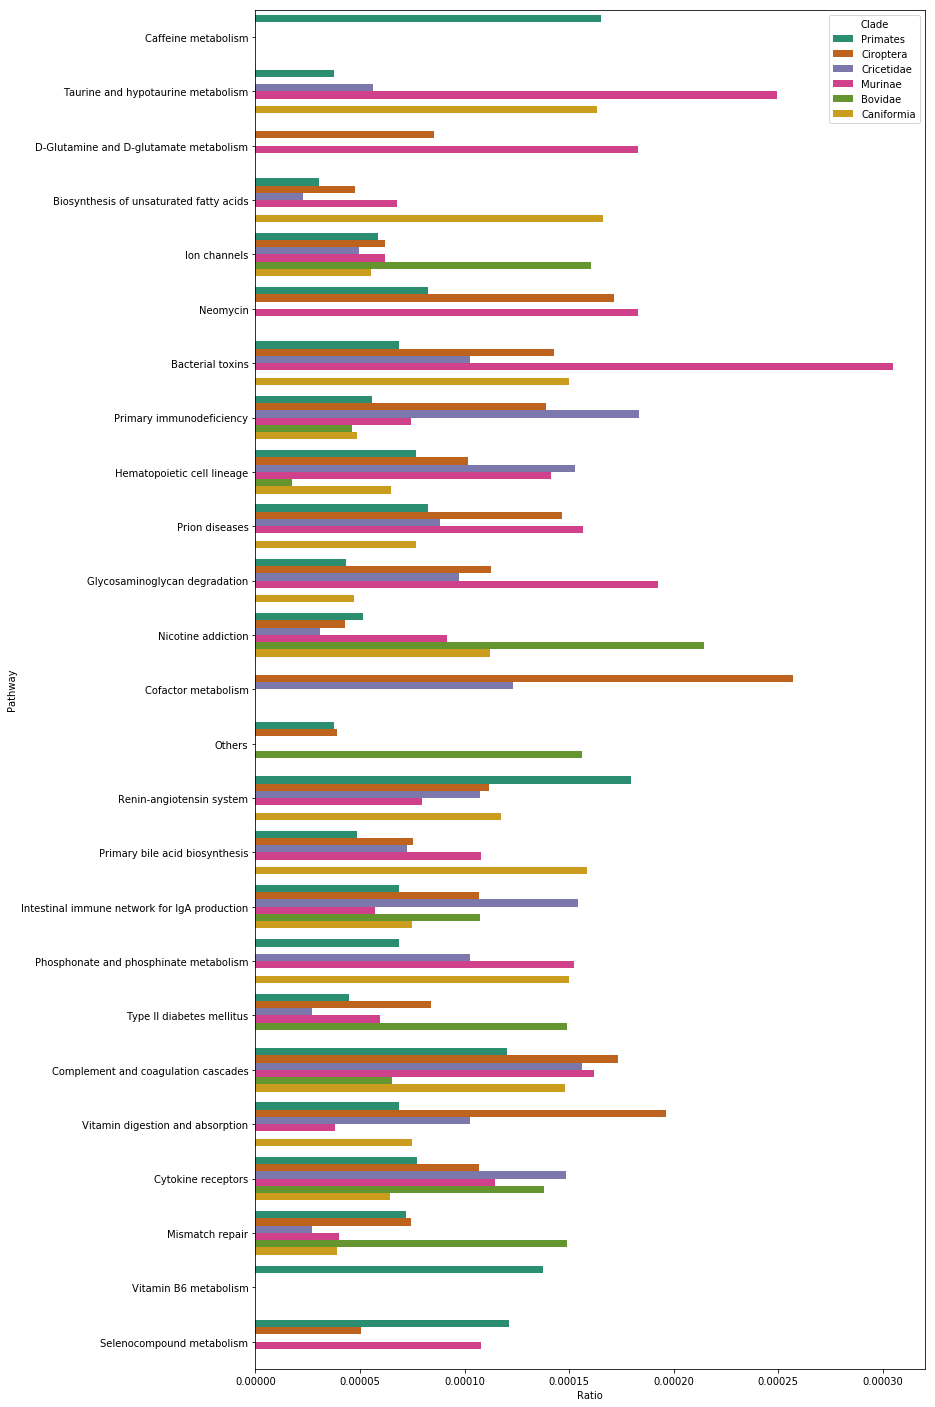

In [16]:
num_hits = 5

tops = []
for kegg in keggs:
    tops.append(most_common(keggs[kegg], num_hits))
tops = set([item for sublist in tops for item in sublist])
print("Top pathways / total possible: {} / {}".format(len(tops), (len(keggs) * num_hits)))
plot_pathways(keggs, names, tops)

There are 25 / 30 pathways when we take the top 5 from each clade. The most heavily represnted pathways look to be Nicotine Addition, Cytokine receptors, Complement and conjugations cascades, intestinal immune network for IgA production, primary immunodeficiency, ion channels.

## 1.5) Rank Order Sum
Instead of ploting the enrichment ratio for the top 5 pathways from each clade, what if we use rank order sum instead? Rank order the pathways from each clade, gather the sum of their ranks, and plot the 10 or so pathways with the lowest value (most highly ranked in the most clades).

In [21]:
def ranks(df):
    """
    Input: Takes a data frame, 
    Return: a list of tuples (pathway, rank) based on the ratio column.
    """
    # sort
    df = df.sort_values(by=['Ratio'], ascending=False)
    # list comp for adding indexes
    rank_list = [(pathway,idx) for idx, pathway in enumerate(df['Pathway'].values)]
    return rank_list

def rank_order_sum(keggs, pathway_num):
    """
    Input: df_dict (keggs), the number of pathways to return
    Return: X pathways that have the lowest rank order sums
    """
    path_ranks = {}
    for kegg in keggs:
        path_ranks[kegg] = ranks(keggs[kegg])

    rank_count = {}
    for kegg in path_ranks:
        for pathway in path_ranks[kegg]:
            if pathway[0] not in rank_count:
                rank_count[pathway[0]] = pathway[1]
            else:
                rank_count[pathway[0]] += pathway[1]

    ## sort it it and make it into a list of just pathways
    rank_sort = sorted(rank_count.items(), key=lambda x: x[1])
    rank_sort = [tup[0] for tup in rank_sort]
    top_ranked_pathways = rank_sort[:pathway_num]

    return top_ranked_pathways

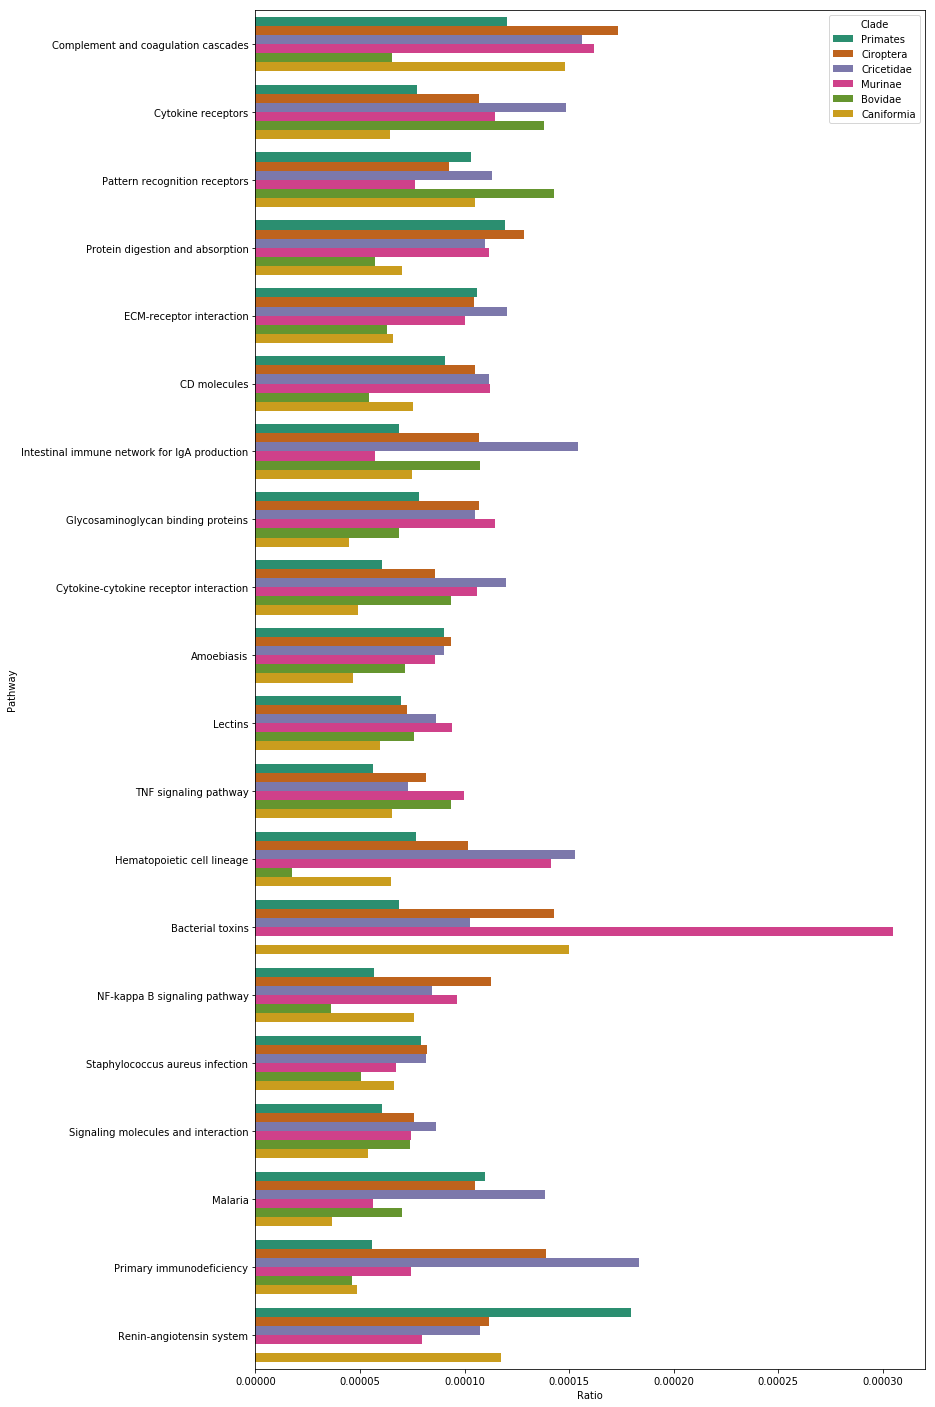

In [23]:
pathway_num = 20
top_ranked_pathways = rank_order_sum(keggs, pathway_num)
plot_pathways(keggs, names, top_ranked_pathways)

## 2) Most Unqiue Pathways
Which pathways have the most descrepency between one clade and the other clades? This could be due to high enrichment in one clade, or high in all clades except one.

In [42]:
def unique_pathways(df_dict, pathway_num):
    """
    Input: df dict, number of pathways to return
    Returns: The most unqiue pathways based on the greatest difference in ratios between all clades
    """
    ratios = {} ## dicitonary to hold a list of ratios for each pathway
    difference = {} ## dicinoary to hold the differences in ratios
    
    ## list of the pathways
    key = list(df_dict.keys())[0]
    df = df_dict[key]
    pathways = df['Pathway'].values
    
    ## get all values for each pathway
    for path in pathways:
        ratios[path] = []
        for key in df_dict:
            df = df_dict[key]
            ratio = float(df[df['Pathway'] == path].values[0][1])
            ratios[path].append(ratio)
    
    ## calculate the difference
    for path in pathways:
        difference[path] = total_difference(ratios[path])
    
    ## sort and slice the list
    most_unique = sorted(difference.items(), key=lambda x: x[1], reverse=True)
    most_unique = [tup[0] for tup in most_unique]
    most_unique = most_unique[:pathway_num]
    
    return most_unique

def total_difference(flist):
    """
    Input: A litst of floats
    Return: The cummulative difference between all those floats (pairwise)
    """
    diff = 0
    for idx1 in range(len(flist)):
        if idx1 < (len(flist)-1):
            for idx2 in range(len(flist[idx1+1:])):
                diff += abs(flist[idx1] - flist[idx2])
    return diff

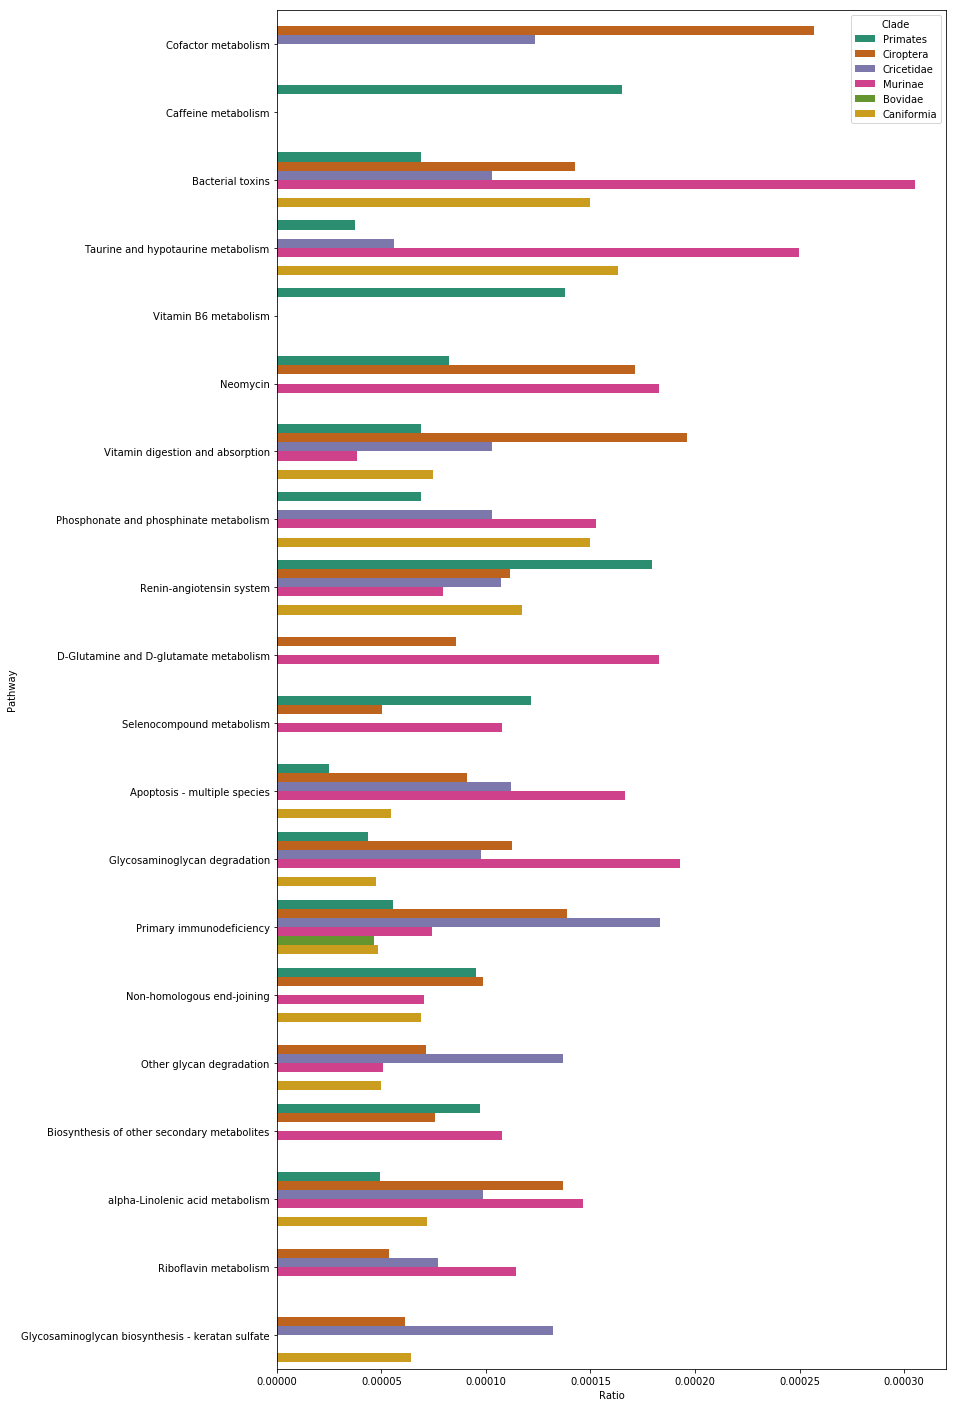

In [43]:
pathway_num = 20
most_unique = unique_pathways(keggs, pathway_num)
plot_pathways(keggs, names, most_unique)